# Notebook to generate plots of simulated datasets results

Be sure to have either downloaded or generated the motion estimation results
before running this notebook. See `../simulated_data/motion_estimation` for
details.

In [2]:
"""Imports."""

import json
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sys
sys.path.append('../simulated_data/motion_estimation')
import utils as motion_estimation_utils

In [11]:
"""Load dataframe."""

data_dict = {
    'dataset': [],
    'method': [],
    'error_l1': [],
    'drift_rate': [],
    'random_walk_sigma': [],
    'random_jump_rate': [],
    'unit_num': [],
    'homogeneity': [],
    'stability': [],
    'non_rigidity': [],
}
_METHODS = [
    'kilosort_datashift',
    'dredge',
    'rigid_fast',
    'medicine_rigid',
    'medicine',
]
_METHOD_NAMES = {
    'kilosort_datashift': 'Kilosort',
    'rigid_fast': 'DREDge\nUniform',
    'medicine_rigid': 'MEDiCINe\nUniform',
    'medicine': 'MEDiCINe',
    'dredge': 'DREDge',
}

for results_dir in motion_estimation_utils.MOTION_ESTIMATION_DIR.iterdir():
    if results_dir.name[0] == '.':
            continue
    if results_dir.name.endswith('.sh'):
        continue
    for error_dir in results_dir.iterdir():
        if error_dir.name[0] == '.':
            continue
        
        method = error_dir.name
        if method not in _METHODS:
            continue
        
        recording_dir = motion_estimation_utils.SIMULATED_DATASETS_DIR / results_dir.name
        hyperparams = json.load(
            open(recording_dir / 'hyperparameters.json', 'r'))
        
        mean_error_path = error_dir / 'mean_error_l1.npy'
        if not mean_error_path.exists():
            continue
        error_l1 = np.load(error_dir / 'mean_error_l1.npy')
        data_dict['dataset'].append(results_dir.name)
        data_dict['method'].append(method)
        data_dict['error_l1'].append(error_l1.item())
        for k, v in hyperparams.items():
            data_dict[k].append(v)
        
dataframe = pd.DataFrame(data_dict)

# Make sure each dataset has all methods
for dataset in dataframe.dataset.unique():
    dataset_df = dataframe[dataframe['dataset'] == dataset]
    for method in _METHODS:
        if method not in dataset_df['method'].values:
            raise ValueError(f'Missing method {method} for dataset {dataset}')

def _get_ranking(values):
    """Get ranking of values, handling ties."""
    ranking = []
    for value in values:
        ranking.append(np.sum(values <= value))
    return ranking
    
# Add method ranking to dataframe
for dataset in dataframe.dataset.unique():
    tmp_df = dataframe.loc[dataframe['dataset'] == dataset]
    num_merge_per_method = [
        tmp_df.loc[tmp_df['method'] == method, 'error_l1'].values[0]
        for method in _METHODS
    ]
    method_ranking = _get_ranking(num_merge_per_method)
    for method, rank in zip(_METHODS, method_ranking):
        dataframe.loc[
            (dataframe['dataset'] == dataset) & (dataframe['method'] == method),
            'method_ranking',
        ] = rank

/var/folders/39/y4130jp93gx8kmc6bw85pr1r0000gn/T/ipykernel_72426/2679609873.py:11: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': 'k'}` instead.

  plot = sns.barplot(
/var/folders/39/y4130jp93gx8kmc6bw85pr1r0000gn/T/ipykernel_72426/2679609873.py:11: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 2}` instead.

  plot = sns.barplot(
/var/folders/39/y4130jp93gx8kmc6bw85pr1r0000gn/T/ipykernel_72426/2679609873.py:11: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': 'k'}` instead.

  plot = sns.barplot(
/var/folders/39/y4130jp93gx8kmc6bw85pr1r0000gn/T/ipykernel_72426/2679609873.py:11: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 2}` instead.

  plot = sns.barplot(


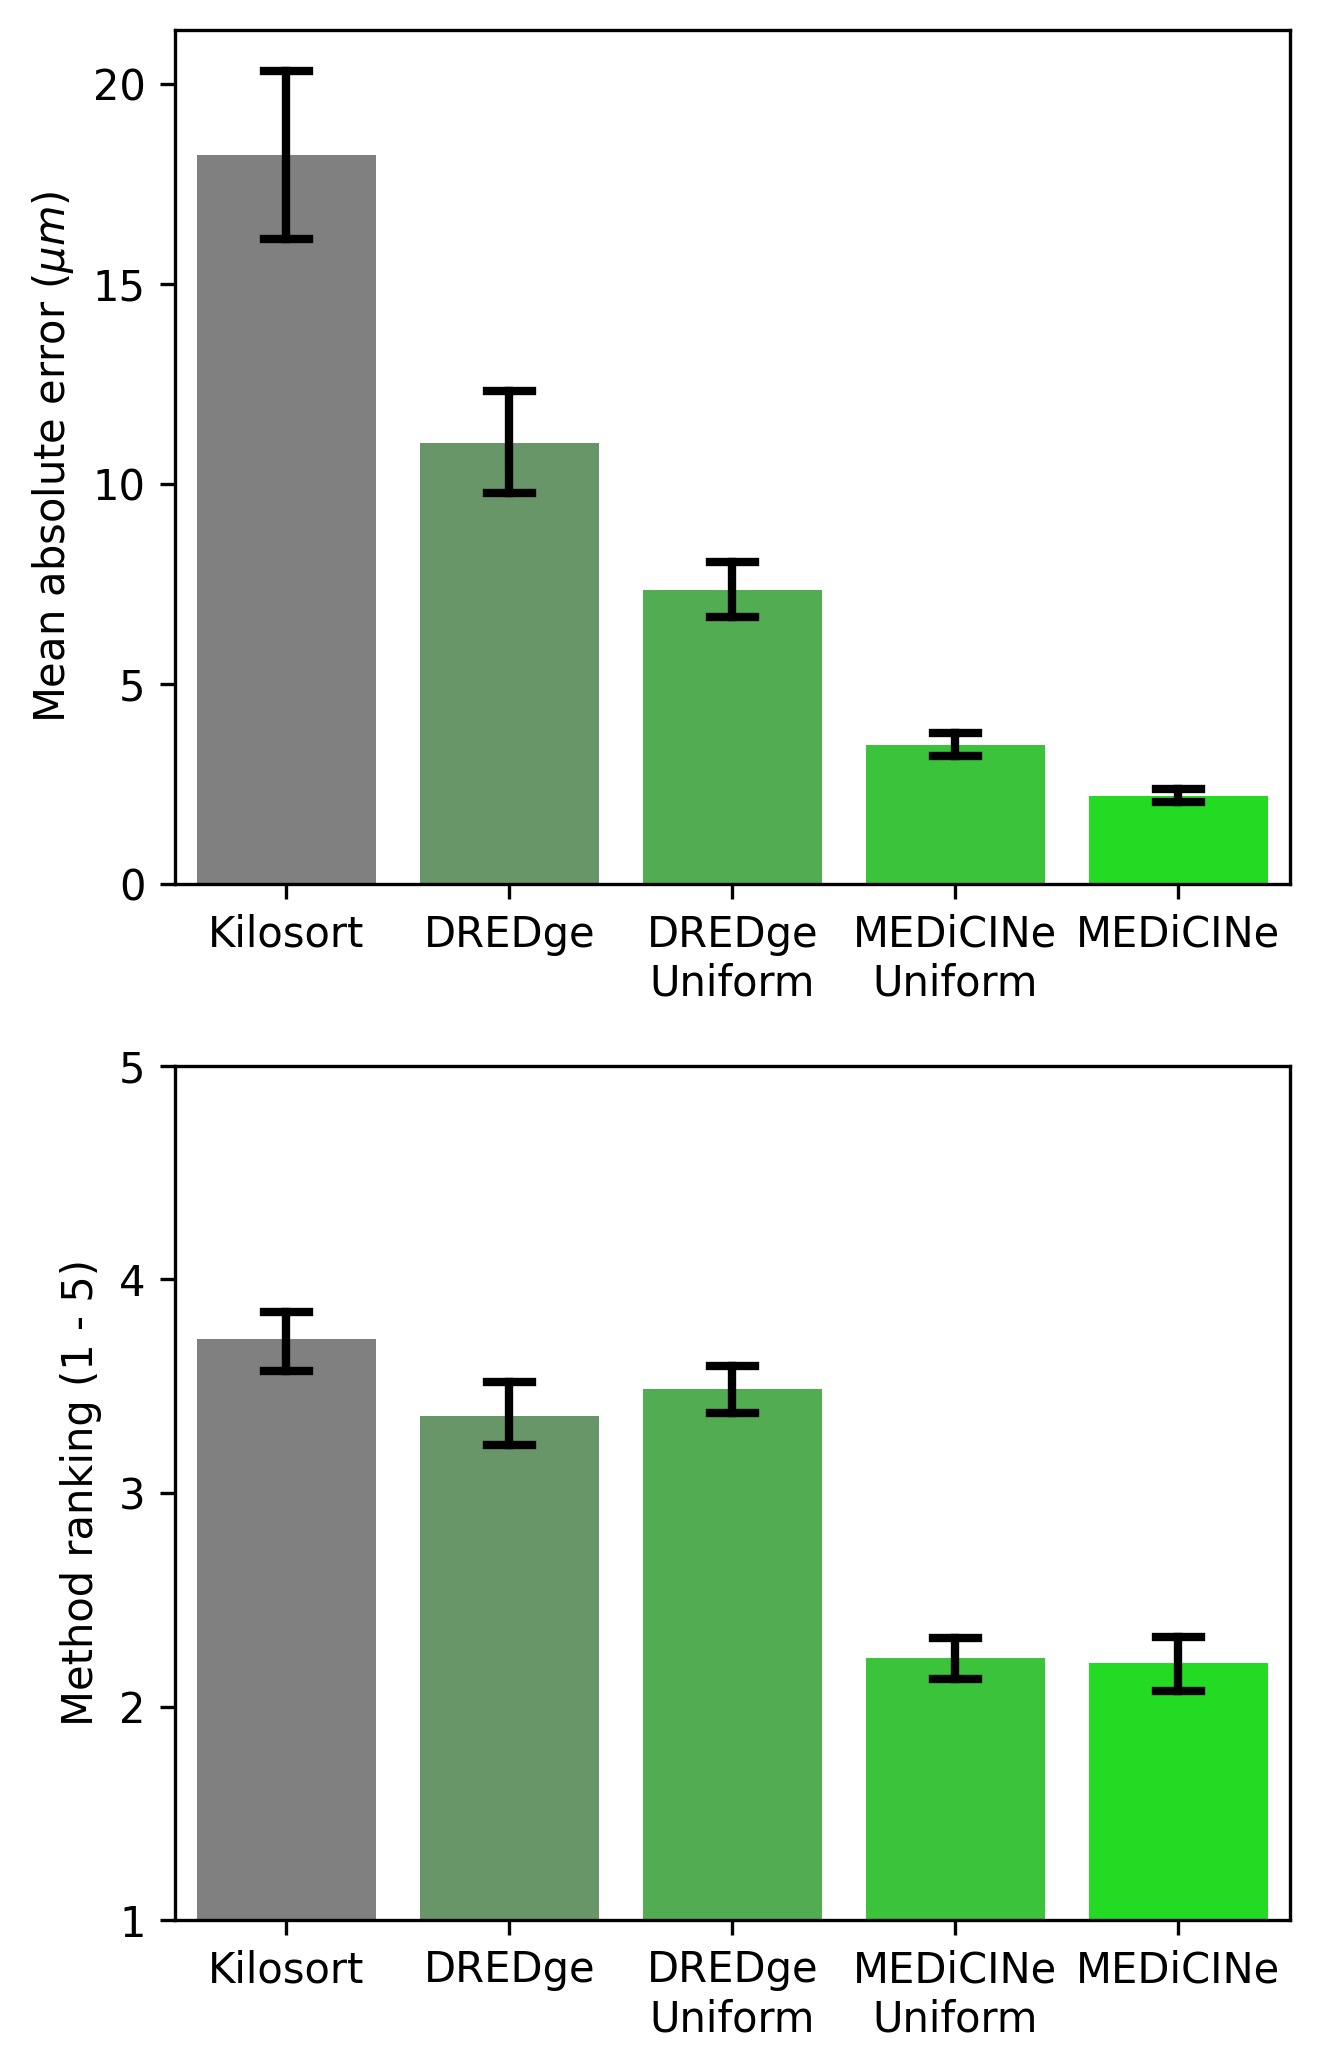

In [12]:
"""Plot errors."""

_PALETTE = {}
for i, method in enumerate(_METHODS):
    step = 0.12
    _PALETTE[method] = (0.5 - step * i, 0.5 + step * i, 0.5 - step * i)

# Plot overall error
fig, axes = plt.subplots(2, 1, figsize=(4.5, 7), dpi=300)
for ax, key in zip(axes, ['error_l1', 'method_ranking']):
    plot = sns.barplot(
        y=key,
        x='method',
        order=_METHODS,
        hue='method', data=dataframe, ax=ax, palette=_PALETTE,
        hue_order=_METHODS, legend=False,
        capsize=0.2, errwidth=2, errcolor='k',
    )
axes[0].set_ylabel('Mean absolute error ($\mu m$)')
axes[0].set_yticks(np.arange(0, 25, 5))
axes[1].set_ylabel('Method ranking (1 - 5)')
axes[1].set_ylim(1, len(_METHODS))
axes[1].set_yticks(np.arange(1, len(_METHODS) + 1))
for ax in axes:
    handles, labels = ax.get_legend_handles_labels()
    ax.set_xticks([bar.get_x() + 0.5 * bar.get_width() for bar in ax.patches])
    ax.set_xticklabels([_METHOD_NAMES[method] for method in _METHODS], rotation=0)
    ax.set_xlabel('')
fig.tight_layout()

In [13]:
"""Print means and confidence intervals of the means."""
for method in _METHODS:
    method_df = dataframe[dataframe['method'] == method]
    mean = method_df['error_l1'].mean()
    std = method_df['error_l1'].std()
    n = len(method_df)
    ci = 1.96 * std / np.sqrt(n)
    print(f'{method}: {mean:.2f} +- {ci:.2f}')


kilosort_datashift: 18.23 +- 2.12
dredge: 11.03 +- 1.32
rigid_fast: 7.36 +- 0.69
medicine_rigid: 3.48 +- 0.28
medicine: 2.21 +- 0.17


In [14]:
"""Plot worst sessions for medicine and medicine_nonrigid."""


def get_worst_datasets(method, num_datasets=2, error_key='error_l1'):
    """Get worst datasets for method."""
    gaps = []
    for dataset in np.unique(dataframe.dataset):
        # Get method error
        dataset_df = dataframe[dataframe.dataset == dataset]
        method_df = dataset_df[dataset_df.method == method]
        if len(method_df) == 0:
            # print(dataset, method)
            continue
        method_error = method_df[error_key].item()
        
        # Get other methods
        other_methods = [
            x for x in dataset_df.method.to_list() if x != method
        ]
        
        # Get other methods errors
        other_methods_errors = [
            dataset_df[dataset_df.method == m][error_key].item()
            for m in other_methods
        ]
        
        # Get gap
        min_other_methods_errors = min(other_methods_errors)
        gap = method_error - min_other_methods_errors
        gaps.append((dataset, gap))
        
    # Sort the gaps
    gaps_values = [g[1] for g in gaps]
    gaps_values_argsort = np.argsort(gaps_values)
    
    # Return datasets for the worst sessions
    bad_indices = gaps_values_argsort[-num_datasets:]
    bad_datasets, bad_gaps = zip(*[gaps[i] for i in bad_indices])
    
    return bad_datasets, bad_gaps
    

def print_dataset(dataset, error_key='error_l1'):
    dataset_df = dataframe[dataframe.dataset == dataset]
    val_per_method = {
        row.method: np.round(row[error_key], decimals=2)
        for _, row in dataset_df.iterrows()
    }
    print(val_per_method)


for method in np.unique(dataframe.method):
    print(f'\n{method}\n')
    for dataset, gap in zip(*get_worst_datasets(method)):
        print(f'dataset, gap = {dataset}, {np.round(gap, decimals=4)}')
        print_dataset(dataset)


dredge

dataset, gap = 0377, 64.495
{'medicine_rigid': 8.24, 'dredge': 67.74, 'kilosort_datashift': 35.16, 'medicine': 3.25, 'rigid_fast': 20.27}
dataset, gap = 0106, 65.0202
{'medicine_rigid': 1.09, 'dredge': 66.11, 'kilosort_datashift': 1.48, 'medicine': 1.24, 'rigid_fast': 12.25}

kilosort_datashift

dataset, gap = 0094, 79.1247
{'medicine_rigid': 3.51, 'dredge': 10.13, 'kilosort_datashift': 82.48, 'medicine': 3.35, 'rigid_fast': 9.57}
dataset, gap = 0191, 82.2429
{'medicine_rigid': 1.97, 'dredge': 1.1, 'kilosort_datashift': 83.35, 'medicine': 2.21, 'rigid_fast': 11.64}

medicine

dataset, gap = 0169, 12.492
{'medicine_rigid': 1.45, 'dredge': 1.08, 'kilosort_datashift': 11.71, 'medicine': 13.57, 'rigid_fast': 2.85}
dataset, gap = 0139, 19.57
{'medicine_rigid': 1.74, 'dredge': 18.35, 'kilosort_datashift': 42.31, 'medicine': 21.31, 'rigid_fast': 31.15}

medicine_rigid

dataset, gap = 0380, 9.8322
{'medicine_rigid': 12.55, 'dredge': 7.76, 'kilosort_datashift': 54.12, 'medicine': 2.72,